Using cache found in /Users/mac/.cache/torch/hub/intel-isl_MiDaS_master
/opt/anaconda3/envs/Computer-vision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /Users/mac/.cache/torch/hub/intel-isl_MiDaS_master


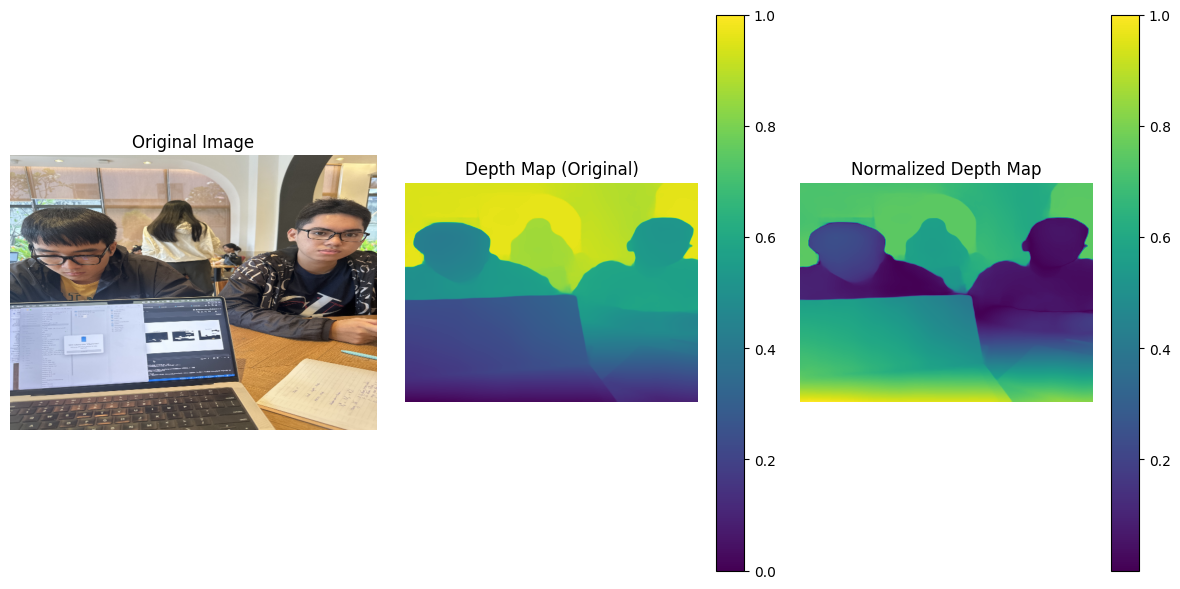

In [1]:
import cv2
import matplotlib.pyplot as plt

import cv2
import torch
import numpy as np

import numpy as np
import pydensecrf.densecrf as dcrf

def apply_crf(image, depth):
    h, w = image.shape[:2]
    d = dcrf.DenseCRF2D(w, h, 2)

    # Chuẩn bị U và pairwise
    U = np.stack([depth.flatten(), 1 - depth.flatten()], axis=0)
    U = -np.log(U + 1e-6)
    U = U.reshape((2, h * w))
    d.setUnaryEnergy(U)

    # Thêm tính năng màu sắc
    d.addPairwiseGaussian(sxy=3, compat=3)
    d.addPairwiseBilateral(sxy=50, srgb=13, rgbim=image, compat=10)

    # Thực hiện suy luận
    Q = d.inference(5)
    depth_crf = np.argmax(Q, axis=0).reshape((h, w))

    return depth_crf.astype('float32')



def load_model(device="cpu"):
    model_type = "DPT_Large"  # MiDaS v3 - Large (highest accuracy, slowest inference speed)
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    device = torch.device(device)
    midas.to(device)
    midas.eval()
    return midas, model_type
def depth_map(img, midas, model_type="DPT_Large", device="cpu"):
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    input_batch = transform(img_rgb).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img_rgb.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()

    # Chuẩn hóa bản đồ độ sâu
    depth_min = output.min()
    depth_max = output.max()
    depth_map = (output - depth_min) / (depth_max - depth_min)
    depth_map = 1.0 - depth_map 
    return depth_map

def depth_transform(depth_map, focus_point):
    depth_map_transform = abs(depth_map - focus_point)
    depth_map_transform /= depth_map_transform.max()  # Chuẩn hóa về [0, 1]
    return depth_map_transform

def blur(depth_map, image, num_levels=5, focus_point=0.5, max_kernel_size=71):
    depth_map = depth_transform(depth_map, focus_point)
    # Tạo danh sách các ngưỡng
    levels = np.linspace(0, 1, num_levels + 1)
    # Tạo danh sách lưu các mặt nạ và độ mờ tương ứng
    masks = []
    blur_values = []

    for i in range(num_levels):
        # Xác định mặt nạ cho mức hiện tại
        lower = levels[i]
        upper = levels[i + 1]
        mask = cv2.inRange(depth_map, lower, upper)
        masks.append(mask)
        
        # Xác định giá trị độ mờ cho mức hiện tại (kernel size)
        kernel_size = int(1 + (max_kernel_size - 1) * (i / (num_levels - 1)))
        if kernel_size % 2 == 0:
            kernel_size += 1  # Đảm bảo kernel_size là số lẻ
        blur_values.append(kernel_size)

    blurred_images = []

    for kernel_size in blur_values:
        # Áp dụng Gaussian blur với kernel_size
        if kernel_size >= 3:
            blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        else:
            blurred = image.copy()
        blurred_images.append(blurred)

    # Khởi tạo ảnh kết quả với giá trị 0
    result = np.zeros_like(image)

    for mask, blurred in zip(masks, blurred_images):
        # Tạo mặt nạ 3 kênh
        mask_3ch = cv2.merge([mask, mask, mask])
        
        # Áp dụng mặt nạ lên ảnh làm mờ và thêm vào ảnh kết quả
        masked_blur = cv2.bitwise_and(blurred, mask_3ch)
        result = cv2.add(result, masked_blur)

    # Tạo mặt nạ tổng hợp từ các mặt nạ đã tạo
    combined_mask = np.zeros_like(depth_map, dtype=np.uint8)
    for mask in masks:
        combined_mask = cv2.bitwise_or(combined_mask, mask)

    # Tạo mặt nạ nghịch đảo cho vùng không được làm mờ
    inverse_mask = cv2.bitwise_not(combined_mask)
    inverse_mask_3ch = cv2.merge([inverse_mask, inverse_mask, inverse_mask])

    # Áp dụng mặt nạ nghịch đảo lên ảnh gốc và thêm vào kết quả
    masked_original = cv2.bitwise_and(image, inverse_mask_3ch)
    result = cv2.add(result, masked_original)

    return result


# Đường dẫn đến ảnh đầu vào
image_path = "/Users/mac/Dev/Computer-vision/Manual-Brokeh/Image.jpeg"  # Thay bằng đường dẫn ảnh của bạn

# Load ảnh
image = cv2.imread(image_path)

# Kiểm tra nếu ảnh không tồn tại
if image is None:
    print("Image not found! Please check the path.")
    exit()

# Resize ảnh (tùy chọn, để tăng tốc xử lý)
image = cv2.resize(image, (640, 480))  # Thay đổi kích thước nếu cần

# Load model MiDaS
device = "cuda" if torch.cuda.is_available() else "cpu"  # Chọn thiết bị CPU/GPU
midas, model_type = load_model(device)

# Dự đoán depth map
depth = depth_map(image, midas, model_type, device)

# Chọn điểm tiêu cự (focus point)
focus_point = 0.55

# Chuẩn hóa depth map theo focus point
normalized_depth = depth_transform(depth, focus_point)

# Hiển thị ảnh gốc và depth map sau khi chuẩn hóa
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Depth Map (Original)")
plt.imshow(depth, cmap="viridis")
plt.colorbar()
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Normalized Depth Map")
plt.imshow(normalized_depth, cmap="viridis")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()


Using cache found in /Users/mac/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/mac/.cache/torch/hub/intel-isl_MiDaS_master


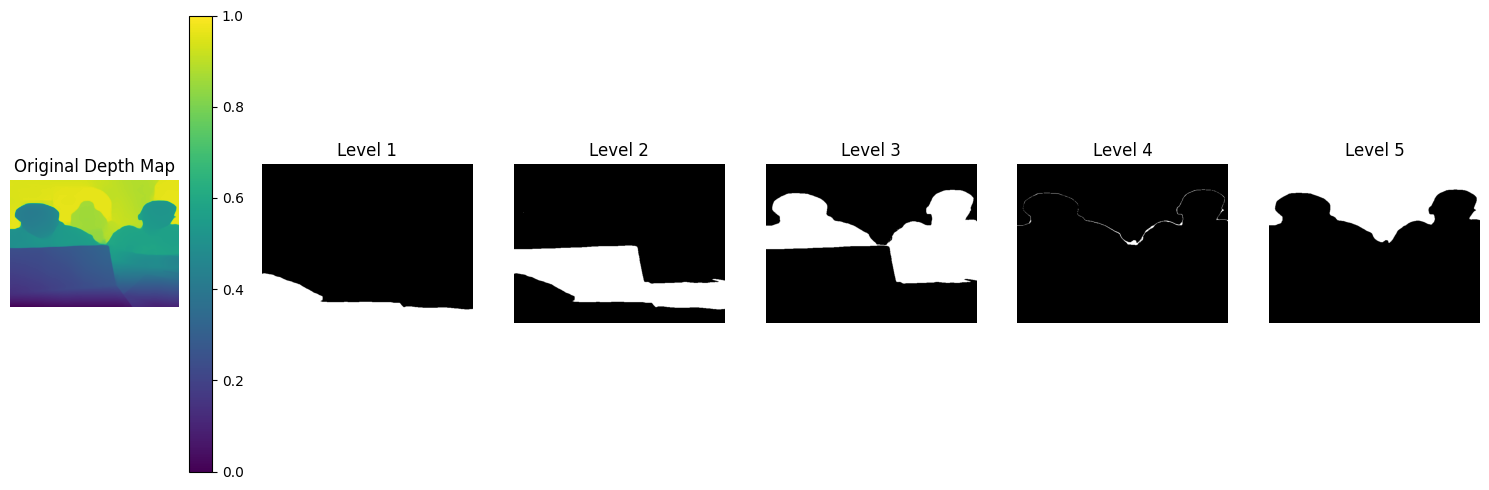

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_depth_levels_and_masks(depth_map, num_levels=5):
    """
    Generate depth levels and corresponding masks from a depth map.
    """
    # Tạo các ngưỡng mức độ sâu
    levels = np.linspace(0, 1, num_levels + 1)  # Chia đều từ 0 đến 1
    masks = []
    for i in range(num_levels):
        # Xác định giới hạn dưới và trên của mỗi lớp
        lower = levels[i]
        upper = levels[i + 1]
        # Tạo mặt nạ nhị phân
        mask = cv2.inRange(depth_map, lower, upper)
        masks.append(mask)
    return levels, masks

def visualize_depth_levels(depth_map, masks, num_levels):
    """
    Visualize the depth levels and their corresponding masks.
    """
    plt.figure(figsize=(15, 5))
    # Hiển thị depth map gốc
    plt.subplot(1, num_levels + 1, 1)
    plt.title("Original Depth Map")
    plt.imshow(depth_map, cmap="viridis")
    plt.colorbar()
    plt.axis("off")
    
    # Hiển thị các lớp độ sâu (masks)
    for i, mask in enumerate(masks):
        plt.subplot(1, num_levels + 1, i + 2)
        plt.title(f"Level {i+1}")
        plt.imshow(mask, cmap="gray")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Load hoặc tính toán depth map
# Thay depth_map bằng bản đồ độ sâu của bạn
image = cv2.imread(image_path)
image = cv2.resize(image, (640, 480))  # Resize nếu cần
device = "cuda" if torch.cuda.is_available() else "cpu"
midas, model_type = load_model(device)
depth = depth_map(image, midas, model_type, device)

# Chuẩn hóa depth map
depth_normalized = (depth - depth.min()) / (depth.max() - depth.min())

# Sinh các levels và masks
num_levels = 5
levels, masks = generate_depth_levels_and_masks(depth_normalized, num_levels)

# Visualize các levels và masks
visualize_depth_levels(depth_normalized, masks, num_levels)


Using cache found in /Users/mac/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/mac/.cache/torch/hub/intel-isl_MiDaS_master


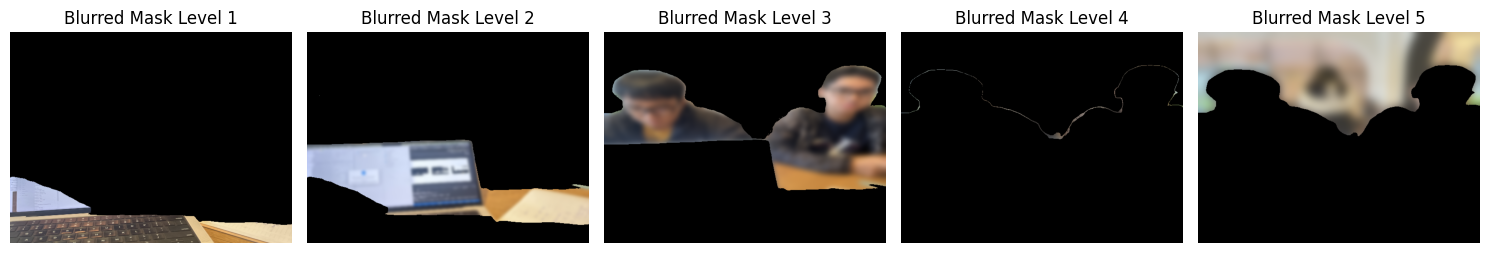

In [12]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_blurred_masks(image, depth_map, num_levels=5, max_kernel_size=71):
    # Normalize the depth map to [0, 1]
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    
    # Generate depth levels and masks
    levels = np.linspace(0, 1, num_levels + 1)
    masks = []
    blurred_images = []

    for i in range(num_levels):
        # Create binary mask for each depth level
        lower = levels[i]
        upper = levels[i + 1]
        mask = cv2.inRange(depth_map, lower, upper)
        masks.append(mask)
        
        # Calculate kernel size for blurring
        kernel_size = int(1 + (max_kernel_size - 1) * (i / (num_levels - 1)))
        if kernel_size % 2 == 0:  # Ensure kernel size is odd
            kernel_size += 1
        
        # Apply Gaussian Blur with the kernel size
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        blurred_images.append(blurred)
    
    # Visualize each blurred mask
    plt.figure(figsize=(15, 5))
    for i, (mask, blurred) in enumerate(zip(masks, blurred_images)):
        # Apply the mask to the blurred image
        mask_3ch = cv2.merge([mask, mask, mask])
        masked_blur = cv2.bitwise_and(blurred, mask_3ch)
        
        # Display the masked blurred region
        plt.subplot(1, num_levels, i + 1)
        plt.title(f"Blurred Mask Level {i+1}")
        plt.imshow(cv2.cvtColor(masked_blur, cv2.COLOR_BGR2RGB))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Example usage
image = cv2.imread(image_path)
image = cv2.resize(image, (640, 480))  # Resize if needed
device = "cuda" if torch.cuda.is_available() else "cpu"
midas, model_type = load_model(device)
depth = depth_map(image, midas, model_type, device)

# Call the function to display masks after applying blur
display_blurred_masks(image, depth, num_levels=5, max_kernel_size=71)


Using cache found in /Users/mac/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/mac/.cache/torch/hub/intel-isl_MiDaS_master


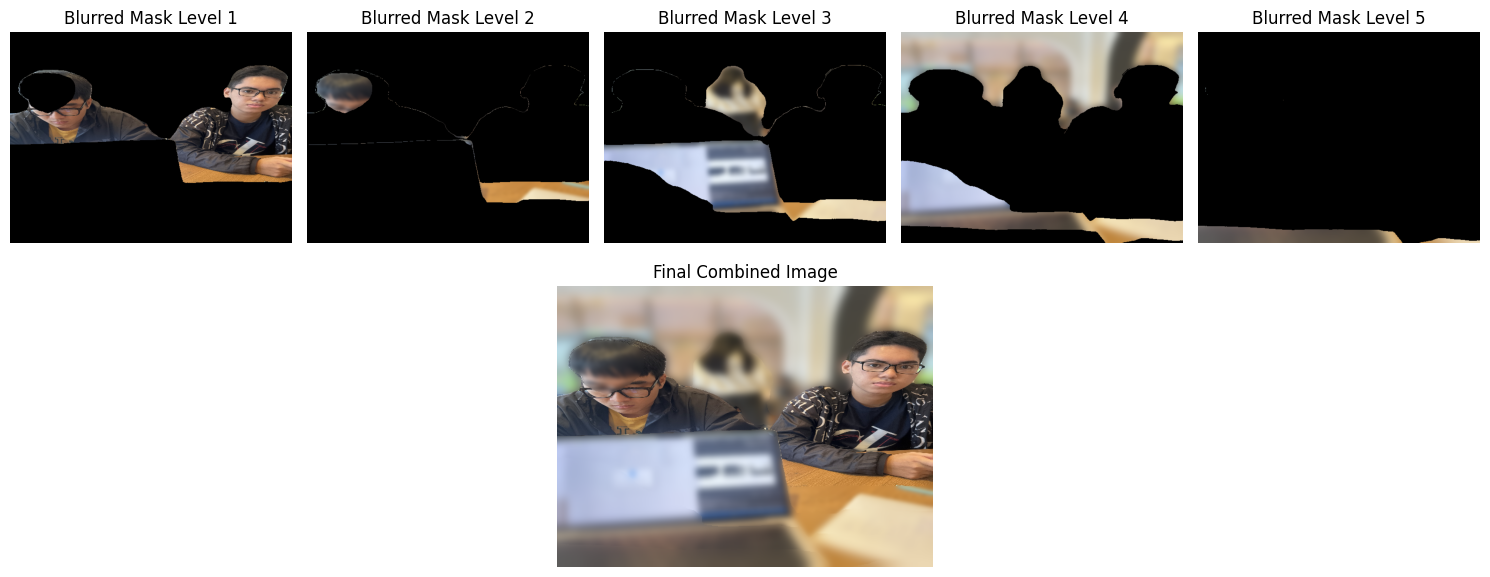

In [13]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_blurred_masks_and_final(image, depth_map, num_levels=5, focus_point=0.5, max_kernel_size=71):
    """
    Display blurred masks for each depth level and the final combined image.
    """
    # Normalize the depth map to [0, 1]
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    
    # Adjust depth map based on the focus point
    depth_map_transformed = abs(depth_map - focus_point)
    depth_map_transformed /= depth_map_transformed.max()  # Normalize to [0, 1]
    
    # Generate depth levels and masks
    levels = np.linspace(0, 1, num_levels + 1)
    masks = []
    blurred_images = []

    for i in range(num_levels):
        # Create binary mask for each depth level
        lower = levels[i]
        upper = levels[i + 1]
        mask = cv2.inRange(depth_map_transformed, lower, upper)
        masks.append(mask)
        
        # Calculate kernel size for blurring
        kernel_size = int(1 + (max_kernel_size - 1) * (i / (num_levels - 1)))
        if kernel_size % 2 == 0:  # Ensure kernel size is odd
            kernel_size += 1
        
        # Apply Gaussian Blur with the kernel size
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        blurred_images.append(blurred)

    # Initialize the result image with zeros
    result = np.zeros_like(image)

    # Combine blurred regions
    for mask, blurred in zip(masks, blurred_images):
        mask_3ch = cv2.merge([mask, mask, mask])  # Convert mask to 3 channels
        masked_blur = cv2.bitwise_and(blurred, mask_3ch)  # Apply mask to blurred image
        result = cv2.add(result, masked_blur)  # Add masked blurred region to result

    # Create combined mask for all blurred regions
    combined_mask = np.zeros_like(depth_map_transformed, dtype=np.uint8)
    for mask in masks:
        combined_mask = cv2.bitwise_or(combined_mask, mask)  # Merge masks

    # Handle non-blurred regions
    inverse_mask = cv2.bitwise_not(combined_mask)  # Create inverse mask
    inverse_mask_3ch = cv2.merge([inverse_mask, inverse_mask, inverse_mask])  # Convert to 3 channels
    masked_original = cv2.bitwise_and(image, inverse_mask_3ch)  # Mask original image
    result = cv2.add(result, masked_original)  # Add non-blurred regions to result

    # Display blurred masks and final result
    plt.figure(figsize=(15, 6))

    # Display each blurred mask
    for i, (mask, blurred) in enumerate(zip(masks, blurred_images)):
        plt.subplot(2, num_levels, i + 1)
        plt.title(f"Blurred Mask Level {i+1}")
        mask_3ch = cv2.merge([mask, mask, mask])
        masked_blur = cv2.bitwise_and(blurred, mask_3ch)
        plt.imshow(cv2.cvtColor(masked_blur, cv2.COLOR_BGR2RGB))
        plt.axis("off")

    # Display the final combined image
    plt.subplot(2, 1, 2)
    plt.title("Final Combined Image")
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
image = cv2.imread(image_path)
image = cv2.resize(image, (640, 480))  # Resize if needed
device = "cuda" if torch.cuda.is_available() else "cpu"
midas, model_type = load_model(device)
depth = depth_map(image, midas, model_type, device)

# Call the function to display blurred masks and the final combined image
display_blurred_masks_and_final(image, depth, num_levels=5, focus_point=0.55, max_kernel_size=71)


Using cache found in /Users/mac/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/mac/.cache/torch/hub/intel-isl_MiDaS_master


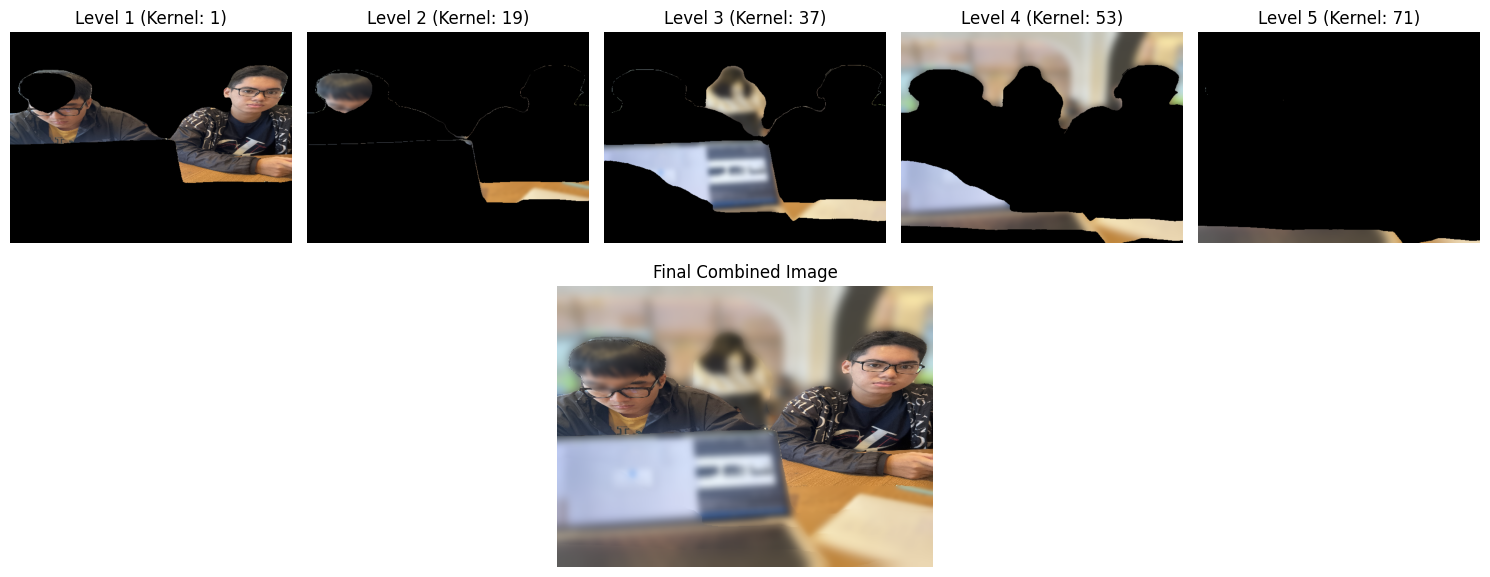

In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_blurred_masks_and_final_with_kernel(image, depth_map, num_levels=5, focus_point=0.5, max_kernel_size=71):
    """
    Display blurred masks for each depth level and the final combined image, with kernel sizes printed.
    """
    # Normalize the depth map to [0, 1]
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    
    # Adjust depth map based on the focus point
    depth_map_transformed = abs(depth_map - focus_point)
    depth_map_transformed /= depth_map_transformed.max()  # Normalize to [0, 1]
    
    # Generate depth levels and masks
    levels = np.linspace(0, 1, num_levels + 1)
    masks = []
    blurred_images = []
    kernel_sizes = []  # Store kernel sizes for each depth level

    for i in range(num_levels):
        # Create binary mask for each depth level
        lower = levels[i]
        upper = levels[i + 1]
        mask = cv2.inRange(depth_map_transformed, lower, upper)
        masks.append(mask)
        
        # Calculate kernel size for blurring
        kernel_size = int(1 + (max_kernel_size - 1) * (i / (num_levels - 1)))
        if kernel_size % 2 == 0:  # Ensure kernel size is odd
            kernel_size += 1
        kernel_sizes.append(kernel_size)
        
        # Apply Gaussian Blur with the kernel size
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        blurred_images.append(blurred)

    # Initialize the result image with zeros
    result = np.zeros_like(image)

    # Combine blurred regions
    for mask, blurred in zip(masks, blurred_images):
        mask_3ch = cv2.merge([mask, mask, mask])  # Convert mask to 3 channels
        masked_blur = cv2.bitwise_and(blurred, mask_3ch)  # Apply mask to blurred image
        result = cv2.add(result, masked_blur)  # Add masked blurred region to result

    # Create combined mask for all blurred regions
    combined_mask = np.zeros_like(depth_map_transformed, dtype=np.uint8)
    for mask in masks:
        combined_mask = cv2.bitwise_or(combined_mask, mask)  # Merge masks

    # Handle non-blurred regions
    inverse_mask = cv2.bitwise_not(combined_mask)  # Create inverse mask
    inverse_mask_3ch = cv2.merge([inverse_mask, inverse_mask, inverse_mask])  # Convert to 3 channels
    masked_original = cv2.bitwise_and(image, inverse_mask_3ch)  # Mask original image
    result = cv2.add(result, masked_original)  # Add non-blurred regions to result

    # Display blurred masks and final result
    plt.figure(figsize=(15, 6))

    # Display each blurred mask
    for i, (mask, blurred, kernel_size) in enumerate(zip(masks, blurred_images, kernel_sizes)):
        plt.subplot(2, num_levels, i + 1)
        plt.title(f"Level {i+1} (Kernel: {kernel_size})")  # Include kernel size in title
        mask_3ch = cv2.merge([mask, mask, mask])
        masked_blur = cv2.bitwise_and(blurred, mask_3ch)
        plt.imshow(cv2.cvtColor(masked_blur, cv2.COLOR_BGR2RGB))
        plt.axis("off")

    # Display the final combined image
    plt.subplot(2, 1, 2)
    plt.title("Final Combined Image")
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()
image_path = "/Users/mac/Dev/Computer-vision/Manual-Brokeh/Image.jpeg" 
# Example usage
image = cv2.imread(image_path)
image = cv2.resize(image, (640, 480))  # Resize if needed
device = "cuda" if torch.cuda.is_available() else "cpu"
midas, model_type = load_model(device)
depth = depth_map(image, midas, model_type, device)

# Call the function to display blurred masks and the final combined image
display_blurred_masks_and_final_with_kernel(image, depth, num_levels=5, focus_point=0.55, max_kernel_size=71)


In [6]:
img_path

NameError: name 'img_path' is not defined

Using cache found in /Users/mac/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/mac/.cache/torch/hub/intel-isl_MiDaS_master


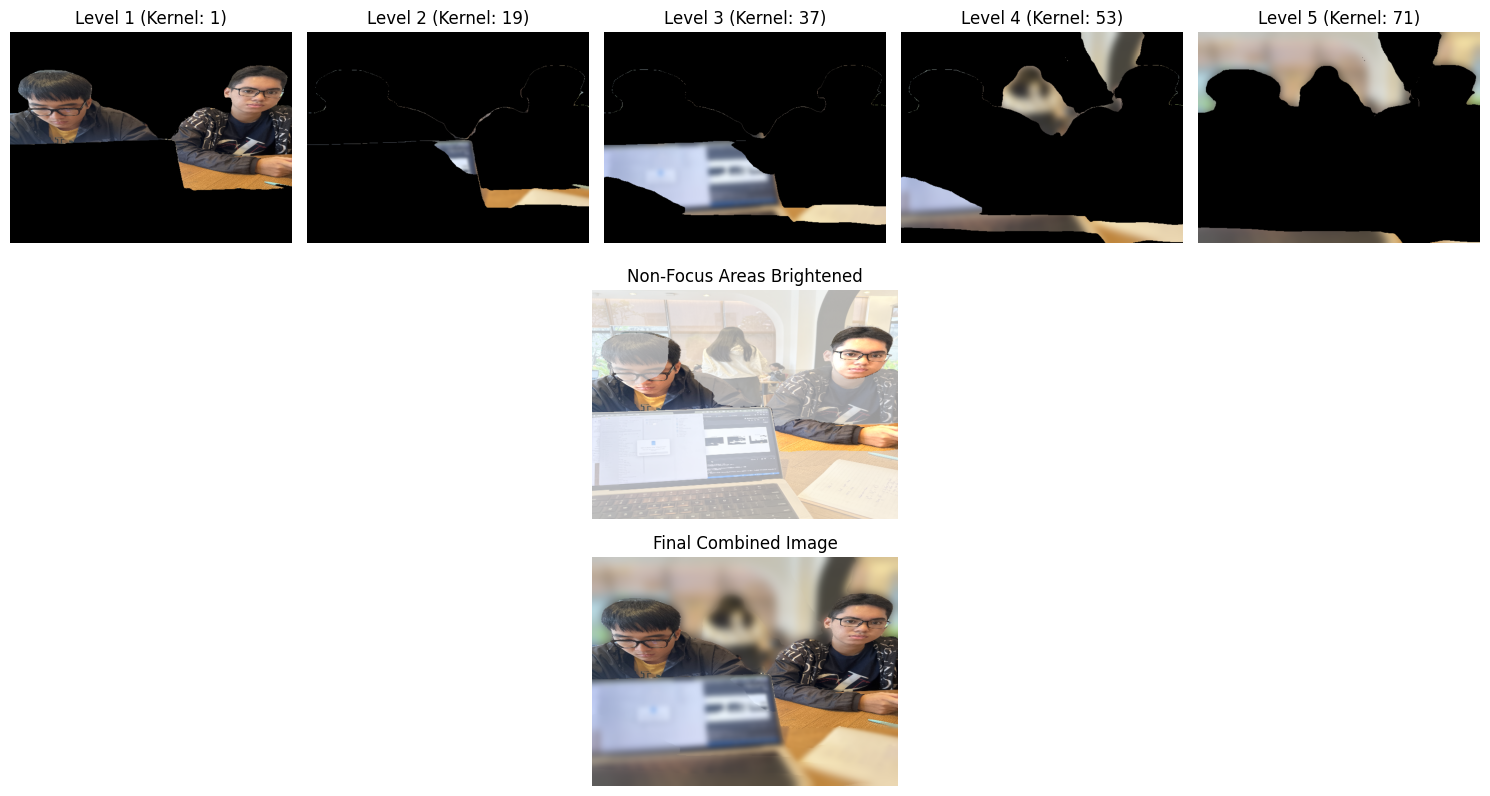

In [5]:
def display_blurred_masks_and_final_with_brightened_non_focus(image, depth_map, num_levels=5, focus_point=0.5, max_kernel_size=71):
    """
    Display blurred masks for each depth level and the final combined image,
    with the non-focus areas brightened while keeping the focus area unchanged.
    """
    # Normalize the depth map to [0, 1]
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    
    # Adjust depth map based on the focus point
    depth_map_transformed = abs(depth_map - focus_point)
    depth_map_transformed /= depth_map_transformed.max()  # Normalize to [0, 1]
    
    # Generate depth levels and masks
    levels = np.linspace(0, 1, num_levels + 1)
    masks = []
    blurred_images = []
    kernel_sizes = []  # Store kernel sizes for each depth level

    for i in range(num_levels):
        # Create binary mask for each depth level
        lower = levels[i]
        upper = levels[i + 1]
        mask = cv2.inRange(depth_map_transformed, lower, upper)
        masks.append(mask)
        
        # Calculate kernel size for blurring
        kernel_size = int(1 + (max_kernel_size - 1) * (i / (num_levels - 1)))
        if kernel_size % 2 == 0:  # Ensure kernel size is odd
            kernel_size += 1
        kernel_sizes.append(kernel_size)
        
        # Apply Gaussian Blur with the kernel size
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        blurred_images.append(blurred)

    # Initialize the result image with zeros
    result = np.zeros_like(image)

    # Combine blurred regions
    for mask, blurred in zip(masks, blurred_images):
        mask_3ch = cv2.merge([mask, mask, mask])  # Convert mask to 3 channels
        masked_blur = cv2.bitwise_and(blurred, mask_3ch)  # Apply mask to blurred image
        result = cv2.add(result, masked_blur)  # Add masked blurred region to result

    # Create combined mask for all blurred regions
    combined_mask = np.zeros_like(depth_map_transformed, dtype=np.uint8)
    for mask in masks:
        combined_mask = cv2.bitwise_or(combined_mask, mask)  # Merge masks

    # Highlight the non-focus area by brightening it
    inverse_focus_mask = cv2.inRange(depth_map_transformed, 0.1, 1)  # Non-focus area
    inverse_focus_mask_3ch = cv2.merge([inverse_focus_mask, inverse_focus_mask, inverse_focus_mask])  # Convert to 3 channels

    # Brighten the non-focus area
    brightened_non_focus = cv2.addWeighted(image, 0.4, inverse_focus_mask_3ch, 0.6, 0)

    # Merge the original focus area with the brightened non-focus area
    focus_mask = cv2.inRange(depth_map_transformed, 0, 0.1)  # Focus area
    focus_mask_3ch = cv2.merge([focus_mask, focus_mask, focus_mask])  # Convert to 3 channels
    focus_area = cv2.bitwise_and(image, focus_mask_3ch)

    highlighted_image = cv2.add(focus_area, brightened_non_focus)  # Combine focus and non-focus areas

    # Display blurred masks, focus, and final result
    plt.figure(figsize=(15, 8))

    # Display each blurred mask
    for i, (mask, blurred, kernel_size) in enumerate(zip(masks, blurred_images, kernel_sizes)):
        plt.subplot(3, num_levels, i + 1)
        plt.title(f"Level {i+1} (Kernel: {kernel_size})")  # Include kernel size in title
        mask_3ch = cv2.merge([mask, mask, mask])
        masked_blur = cv2.bitwise_and(blurred, mask_3ch)
        plt.imshow(cv2.cvtColor(masked_blur, cv2.COLOR_BGR2RGB))
        plt.axis("off")

    # Display the focus-highlighted image
    plt.subplot(3, 1, 2)
    plt.title("Non-Focus Areas Brightened")
    plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    # Display the final combined image
    plt.subplot(3, 1, 3)
    plt.title("Final Combined Image")
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
# image_path = "path_to_your_image.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, (640, 480))  # Resize if needed
device = "mps" if torch.cuda.is_available() else "cpu"
midas, model_type = load_model(device)
depth = depth_map(image, midas, model_type, device)

# Call the function to display blurred masks and final combined image with brightened non-focus areas
display_blurred_masks_and_final_with_brightened_non_focus(image, depth, num_levels=5, focus_point=0.5, max_kernel_size=71)


In [8]:
import torch
import segmentation_models_pytorch as smp

# Khởi tạo mô hình
model = smp.UnetPlusPlus(
    encoder_name='resnet50',        # Backbone encoder      # Pretrained weights
    in_channels=3,                   # Số kênh đầu vào (3 cho ảnh RGB)
    classes=1                        # Số kênh đầu ra (1 cho depth map)
)

# Load checkpoint
checkpoint = torch.load('/Users/mac/Dev/Computer-vision/Manual-Brokeh/model_prepair/U++.pt', map_location=torch.device('cpu'))

# Nếu checkpoint lưu ở dạng {'model_state_dict': ...} thì cần tách ra:
# state_dict = checkpoint['model_state_dict']
# Nếu checkpoint là state_dict thuần thì bỏ qua dòng trên

# Ví dụ checkpoint ở dạng state_dict thuần:
state_dict = checkpoint

# Loại bỏ tiền tố "model."
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("model."):
        new_key = k.replace("model.", "")
    else:
        new_key = k
    new_state_dict[new_key] = v

# Load state_dict đã được chỉnh sửa vào mô hình
model.load_state_dict(new_state_dict)

print("Checkpoint loaded successfully!")


Checkpoint loaded successfully!


/var/folders/0j/2h4f0bj12r775fg_s2v4hpqh0000gn/T/ipykernel_2343/1527796602.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/Users/mac/Dev/Compu

In [27]:
import cv2 as cv
im = cv.imread("/Users/mac/Dev/Computer-vision/Manual-Brokeh/Image.jpeg")
# OpenCV trả về BGR, thường ta cần chuyển sang RGB trước khi đưa vào model
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

transformed = transform(image=im)
im_tensor = transformed['image']  # Dạng (C,H,W)

im_tensor=im_tensor.unsqueeze(0)
pred=model(im_tensor)
pred=pred.cpu()
pred=pred.detach()
pred=np.array(pred)

In [29]:
import cv2 as cv2
import cv2
import matplotlib.pyplot as plt

import cv2
import torch
import numpy as np

import numpy as np
import pydensecrf.densecrf as dcrf
def display_blurred_masks_and_final_with_brightened_non_focus(image, depth_map, num_levels=5, focus_point=0.5, max_kernel_size=71):
    """
    Display blurred masks for each depth level and the final combined image,
    with the non-focus areas brightened while keeping the focus area unchanged.
    """
    # Normalize the depth map to [0, 1]
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    
    # Adjust depth map based on the focus point
    depth_map_transformed = abs(depth_map - focus_point)
    depth_map_transformed /= depth_map_transformed.max()  # Normalize to [0, 1]
    
    # Generate depth levels and masks
    levels = np.linspace(0, 1, num_levels + 1)
    masks = []
    blurred_images = []
    kernel_sizes = []  # Store kernel sizes for each depth level

    for i in range(num_levels):
        # Create binary mask for each depth level
        lower = levels[i]
        upper = levels[i + 1]
        mask = cv2.inRange(depth_map_transformed, lower, upper)
        masks.append(mask)
        
        # Calculate kernel size for blurring
        kernel_size = int(1 + (max_kernel_size - 1) * (i / (num_levels - 1)))
        if kernel_size % 2 == 0:  # Ensure kernel size is odd
            kernel_size += 1
        kernel_sizes.append(kernel_size)
        
        # Apply Gaussian Blur with the kernel size
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        blurred_images.append(blurred)

    # Initialize the result image with zeros
    result = np.zeros_like(image)

    # Combine blurred regions
    for mask, blurred in zip(masks, blurred_images):
        mask_3ch = cv2.merge([mask, mask, mask])  # Convert mask to 3 channels
        masked_blur = cv2.bitwise_and(blurred, mask_3ch)  # Apply mask to blurred image
        result = cv2.add(result, masked_blur)  # Add masked blurred region to result

    # Create combined mask for all blurred regions
    combined_mask = np.zeros_like(depth_map_transformed, dtype=np.uint8)
    for mask in masks:
        combined_mask = cv2.bitwise_or(combined_mask, mask)  # Merge masks

    # Highlight the non-focus area by brightening it
    inverse_focus_mask = cv2.inRange(depth_map_transformed, 0.1, 1)  # Non-focus area
    inverse_focus_mask_3ch = cv2.merge([inverse_focus_mask, inverse_focus_mask, inverse_focus_mask])  # Convert to 3 channels

    # Brighten the non-focus area
    brightened_non_focus = cv2.addWeighted(image, 0.4, inverse_focus_mask_3ch, 0.6, 0)

    # Merge the original focus area with the brightened non-focus area
    focus_mask = cv2.inRange(depth_map_transformed, 0, 0.1)  # Focus area
    focus_mask_3ch = cv2.merge([focus_mask, focus_mask, focus_mask])  # Convert to 3 channels
    focus_area = cv2.bitwise_and(image, focus_mask_3ch)

    highlighted_image = cv2.add(focus_area, brightened_non_focus)  # Combine focus and non-focus areas

    # Display blurred masks, focus, and final result
    plt.figure(figsize=(15, 8))

    # Display each blurred mask
    for i, (mask, blurred, kernel_size) in enumerate(zip(masks, blurred_images, kernel_sizes)):
        plt.subplot(3, num_levels, i + 1)
        plt.title(f"Level {i+1} (Kernel: {kernel_size})")  # Include kernel size in title
        mask_3ch = cv2.merge([mask, mask, mask])
        masked_blur = cv2.bitwise_and(blurred, mask_3ch)
        plt.imshow(cv2.cvtColor(masked_blur, cv2.COLOR_BGR2RGB))
        plt.axis("off")

    # Display the focus-highlighted image
    plt.subplot(3, 1, 2)
    plt.title("Non-Focus Areas Brightened")
    plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    # Display the final combined image
    plt.subplot(3, 1, 3)
    plt.title("Final Combined Image")
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# # Example usage
# # image_path = "path_to_your_image.jpg"
# image = cv2.imread(image_path)
# image = cv2.resize(image, (640, 480))  # Resize if needed
# device = "mps" if torch.cuda.is_available() else "cpu"
# midas, model_type = load_model(device)
# depth = depth_map(image, midas, model_type, device)

mask = cv2.resize(pred, (im.shape[1], im.shape[0]))


# Call the function to display blurred masks and final combined image with brightened non-focus areas
display_blurred_masks_and_final_with_brightened_non_focus(im, masK, num_levels=5, focus_point=0.5, max_kernel_size=71)


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:3789: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


In [34]:
im

array([[[189, 190, 182],
        [188, 189, 181],
        [187, 188, 180],
        ...,
        [208, 186, 145],
        [210, 188, 147],
        [211, 189, 148]],

       [[188, 189, 181],
        [188, 189, 181],
        [187, 188, 180],
        ...,
        [209, 187, 146],
        [211, 189, 148],
        [213, 191, 150]],

       [[183, 184, 178],
        [184, 185, 179],
        [185, 186, 180],
        ...,
        [208, 186, 145],
        [210, 188, 147],
        [211, 189, 148]],

       ...,

       [[ 95,  95,  93],
        [ 95,  95,  93],
        [ 93,  93,  91],
        ...,
        [235, 215, 178],
        [236, 216, 179],
        [236, 216, 179]],

       [[ 95,  95,  93],
        [ 95,  95,  93],
        [ 95,  95,  93],
        ...,
        [235, 215, 178],
        [235, 215, 178],
        [235, 215, 178]],

       [[ 90,  90,  88],
        [ 91,  91,  89],
        [ 94,  94,  92],
        ...,
        [236, 216, 179],
        [235, 215, 178],
        [235, 215, 178]]